# Bruco (Brute force coherence) Pythonチュートリアル

Brucoは**「総当たりコヒーレンス（Brute force coherence）」**を計算するためのツールです。重力波検出器（LIGOやVirgo）の主チャンネル（ターゲット）と、多数の補助チャンネルとの間のコヒーレンスを計算し、ノイズ源を特定することを目的としています。

#### 並列処理によるコヒーレンス計算

Pythonの `multiprocessing` モジュールを使用して複数のCPUコアで並列実行されます。

1. **タスク分割**: 全補助チャンネルリストをCPU数に応じて分割し、各プロセスに割り当てます。
2. **データ取得と前処理**:
* 各補助チャンネルのデータを取得します。
* データが一定（フラット）の場合はスキップします。
* サンプリングレートが出力要求レート (`outfs`) より高い場合、`decimate` 関数を用いてダウンサンプリングします。
3. **コヒーレンス算出**:
* 補助チャンネルのFFTとPSD（パワースペクトル密度）を計算します。
* ターゲットチャンネルとのCSD（クロススペクトル密度）を計算します。
* コヒーレンス  を以下の式で計算します：
4. **Top N の選出**:
* すべての周波数ビンについて、計算されたコヒーレンス値が既存の上位リスト（`top`）よりも高い場合、その値を更新します。これにより、全チャンネルの結果を保持するのではなく、相関の高い上位チャンネルのみを効率的に記録します。
5. **結果の集約と出力**:
* 各プロセスから返された `cohtab`（コヒーレンス値）と `idxtab`（チャンネルID）を結合・ソートし、最終的な上位リストを作成します。
* **HTMLレポート作成**: `markup.py` を使用して `index.html` を生成します。これには、周波数ごとの上位相関チャンネルの表（ヒートマップ形式の着色あり）や、プロット画像へのリンクが含まれます。
* **プロット作成**: `matplotlib` を使用して、コヒーレンスとスペクトルのグラフ（PNGまたはPDF）を生成します。

この実装は、大量のチャンネルデータを効率的に処理するために、**FFTの事前計算**、**並列処理**、および**メモリ効率の良いTop-N記録方式**を採用している点が特徴です。

オリジナルのBruco実装は以下で公開されています。設計詳細やCLIの挙動を確認したい場合はこちらを参照してください。
- https://github.com/mikelovskij/bruco

このノートブックでは `gwexpy` の `Bruco` モジュールを **Pythonライブラリとして** 使う利点を体感するために、
対話的な解析・柔軟なデータ操作・高度な仮説検証を一通り実演します。

- 実データは使わず、`gwpy` / `numpy` で生成した擬似データを利用します。
- CLIでは難しい「非線形結合」や「変調」の仮説検証を、Python APIで高速に試します。


## セットアップとモックデータ生成

**何をするか**: ターゲット/補助チャンネルの擬似データを作り、Brucoに食わせるための `TimeSeries` を準備します。  
**なぜ重要か**: 実運用ではNDSやフレームから取得しますが、ノートブック上で自由に信号を設計できると仮説検証が加速します。


In [1]:
# ruff: noqa: I001
import warnings

warnings.filterwarnings("ignore")
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.analysis import Bruco
from gwexpy.analysis.bruco import FastCoherenceEngine
from gwexpy.astro import inspiral_range
from gwexpy.frequencyseries import FrequencySeriesDict
from gwexpy.noise.asd import from_pygwinc
from gwexpy.noise.wave import from_asd
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries, TimeSeriesDict

AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

In [2]:
rng = np.random.default_rng(7)

duration = 128  # seconds
sample_rate = 2048  # Hz
fftlength = 4.0  # seconds
overlap = 2.0  # seconds

t = np.arange(0, duration, 1 / sample_rate)

# aLIGOの感度曲線(ASD)を取得
fmax = sample_rate / 2  # Nyquist frequency
asd_aligo = from_pygwinc(
    "aLIGO", fmin=4.0, fmax=fmax, df=1.0 / duration, quantity="strain"
)

# aLIGOの感度曲線に基づくターゲットノイズを生成
target = from_asd(asd_aligo, duration, sample_rate, t0=0, rng=rng).highpass(1)
target.channel = "H1:TARGET"

# 補助チャンネル用の信号
fast_line = np.sin(2 * np.pi * 60.0 * t)
slow_motion = 70 * np.sin(2 * np.pi * 2.3 * t) + 30 * np.sin(2 * np.pi * 7.1 * t)

aux1_data = 0.8 * fast_line + 0.2 * rng.normal(0, 1.0, size=t.size)
aux2_data = 0.9 * slow_motion + 0.2 * rng.normal(0, 1.0, size=t.size) + 1
aux1 = TimeSeries(
    aux1_data, sample_rate=sample_rate, t0=0, unit="V", channel="H1:AUX1_FAST"
)
aux2 = TimeSeries(
    aux2_data, sample_rate=sample_rate, t0=0, unit="V", channel="H1:AUX2_SLOW"
).lowpass(30)

# ターゲットへの注入信号: aLIGOベースノイズ + 線形カップリング + 非線形注入
target = target + 1e-22 * target.unit * (
    aux1 / u.V + aux2 / u.V + (aux1 / u.V / 2) ** 2 + 0.01 * (aux1 * aux2 / u.V**2)
)


target.name = target.channel
aux1.name = aux1.channel
aux2.name = aux2.channel

aux_dict = TimeSeriesDict(
    {
        aux1.channel: aux1,
        aux2.channel: aux2,
    }
)

print(f"aLIGO ASD at 100 Hz: {asd_aligo.crop(99, 101).value[0]:.2e} strain/sqrt(Hz)")
print(f"Target data std: {target.std():.2e}")

plot = Plot(
    [target.asd(8, 4), asd_aligo],
    aux1.asd(8, 4),
    aux2.asd(8, 4),
    figsize=(10, 12),
    sharex=True,
)
axes = plot.get_axes()
axes[0].set_xlim(1, 1e3)
axes[0].set_ylim(1e-24, 1e-19)
axes[1].set_ylim(1e-3, 1e1)
axes[2].set_ylim(1e-4, 1e3)
axes[0].legend([target.name, "Model ASD"])
axes[1].legend([aux1.name])
axes[2].legend([aux2.name]);

NameError: name 'from_pygwinc' is not defined

## Section 1: 基本的なBruco解析の実行 (Jupyter上での再現)

**何をするか**: `Bruco` クラスで総当たりコヒーレンス解析を実行し、結果をテーブルとプロットで確認します。  
**なぜ重要か**: Python APIなら、対話的に条件や可視化を変えながら“犯人探し”を素早く試せます。


In [3]:
# Brucoの初期化。
# ここではデータは全て手動で渡すため、NDSからの自動取得チャンネルリスト(aux_channels)は空リストを指定します。
bruco = Bruco(target_channel=target.name, aux_channels=[])

# computeメソッドに target_data と aux_data を渡すことで、内部Fetchをスキップして解析を実行できます。
result = bruco.compute(
    start=0,
    duration=int(duration),
    fftlength=fftlength,
    overlap=overlap,
    nproc=1,
    batch_size=2,
    top_n=3,
    target_data=target,  # 事前に生成したターゲットデータ
    aux_data=aux_dict,  # 事前に生成した補助チャンネルデータの辞書
)

NameError: name 'Bruco' is not defined

In [4]:
df = result.to_dataframe(ranks=[0])

df_sorted = (
    df.sort_values("coherence", ascending=False)
    .dropna(subset=["channel"])
    .head(15)
    .reset_index(drop=True)
)

df_sorted

NameError: name 'result' is not defined

In [5]:
result.plot_projection(coherence_threshold=0.5)
plt.xlim(4, 1000)
plt.show()

result.plot_coherence(coherence_threshold=0.5)
plt.xlim(1, 1000)
plt.show()

NameError: name 'result' is not defined

In [6]:
report_path = result.generate_report("bruco_report", coherence_threshold=0.4)
report_path

NameError: name 'result' is not defined

## Section 2: 高度な前処理と仮説検証 (Deep Dive: Nonlinear & Bilinear)

**何をするか**: 既存の線形相関だけでは説明できないノイズを想定し、非線形結合（2乗）や変調（積）を仮説として検定します。  
**なぜ重要か**: `FastCoherenceEngine` を使うと、ターゲットのFFTを再計算せずに仮想チャンネルを高速に試せます。


In [7]:
ts_sq = aux1**2
ts_sq.name = f"{aux1.name}^2"

ts_prod = aux1 * aux2
ts_prod.name = f"{aux1.name}*{aux2.name}"

NameError: name 'aux1' is not defined

In [8]:
engine = FastCoherenceEngine(target, fftlength=fftlength, overlap=overlap)

coh_linear = engine.compute_coherence(aux1)
coh_sq = engine.compute_coherence(ts_sq)
coh_prod = engine.compute_coherence(ts_prod)

freqs = engine.frequencies

NameError: name 'FastCoherenceEngine' is not defined

NameError: name 'freqs' is not defined

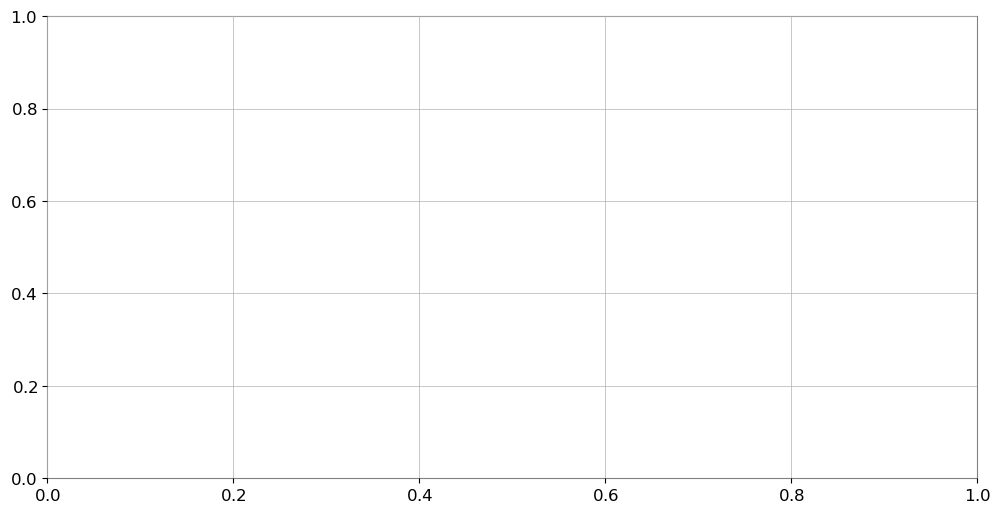

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogx(freqs, coh_linear, label=f"Linear: {aux1.name}")
ax.semilogx(freqs, coh_sq, label=f"Squared: {ts_sq.name}")
ax.semilogx(freqs, coh_prod, label=f"Product: {ts_prod.name}")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Coherence")
ax.set_ylim(0.0, 1.0)
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()

## Section 3: 下流解析への接続 (Actionable Outcome)

**何をするか**: もっとも寄与が大きいノイズ仮説を用いて残差スペクトルを推定し、BNS Rangeの改善量を見積もります。  
**なぜ重要か**: Bruco結果を“見つけて終わり”にせず、感度改善やノイズ除去ワークフローにつなげられます。


In [10]:
target_asd = target.asd(fftlength=fftlength, overlap=overlap)
target_asd_vals = target_asd.value

coh_map = {
    aux1.name: coh_linear,
    ts_sq.name: coh_sq,
    ts_prod.name: coh_prod,
}

dominant_label = max(coh_map, key=lambda k: np.nanmax(coh_map[k]))
dominant_coh = coh_map[dominant_label]

# Brucoの投影式と同じ定義で、仮想チャンネルの寄与をASDで推定
projected_asd = target_asd_vals * np.sqrt(dominant_coh)
residual_asd_vals = np.sqrt(np.maximum(target_asd_vals**2 - projected_asd**2, 0.0))

residual_asd = target_asd.copy()
residual_asd.value[:] = residual_asd_vals

fig, ax = plt.subplots(figsize=(12, 6))
# ax.loglog(target_asd.frequencies.value, target_asd_vals, label="Target ASD")
# ax.loglog(target_asd.frequencies.value, residual_asd_vals, label="Residual ASD")
ax.loglog(target_asd, label="Target ASD")
ax.loglog(residual_asd, label="Residual ASD")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("ASD")
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend()
plt.show()

# BNS Rangeの比較
bns_range_before = inspiral_range(target_asd**2, mass1=1.4, mass2=1.4, fmin=10)
bns_range_after = inspiral_range(residual_asd**2, mass1=1.4, mass2=1.4, fmin=10)

print(f"Dominant hypothesis: {dominant_label}")
print(f"BNS range (before): {bns_range_before.to_value(u.Mpc):.2f} Mpc")
print(f"BNS range (after):  {bns_range_after.to_value(u.Mpc):.2f} Mpc")

NameError: name 'target' is not defined

In [11]:
virtual_channels = {
    aux1.name: aux1,
    ts_sq.name: ts_sq,
    ts_prod.name: ts_prod,
}

culprit_channels = [dominant_label]
witnesses = TimeSeriesDict({name: virtual_channels[name] for name in culprit_channels})

cxx = witnesses.csd_matrix(fftlength=8.0)
cyx = TimeSeriesDict({"TARGET": target}).csd_matrix(other=witnesses, fftlength=8.0)

# 行列演算 H = Cyx @ Cxx^-1
H_lowres = cyx @ cxx.inv()

# 推定された伝達関数の表示
H_lowres.abs().plot(xscale="log", yscale="log").suptitle("Estimated MIMO Coupling (H)")
plt.show()

# フル解像度のFFT


tsd = TimeSeriesDict({"MAIN": target, **witnesses})
aux_names = culprit_channels

tsd_fft = tsd.fft()
main_fft = tsd_fft["MAIN"]

# フィルターの補間と行列演算
H = H_lowres.interpolate(main_fft.frequencies)
X_mat = FrequencySeriesDict({k: tsd_fft[k] for k in aux_names}).to_matrix()

# 投影と減算
Y_proj = (H @ X_mat)[0, 0]
cleaned_fft = main_fft - Y_proj

# 時間領域へ
cleaned_ts = cleaned_fft.ifft()

NameError: name 'aux1' is not defined

NameError: name 'target' is not defined

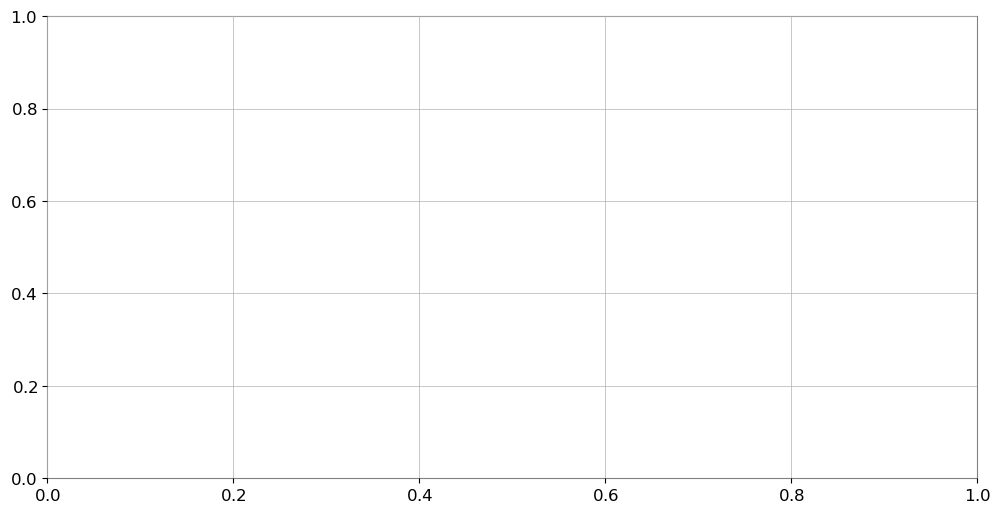

In [12]:
# ノイズ除去効果の確認
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()

# 元のデータと除去後のデータを重ねてプロット (最初の1秒間)
plot_duration = 1.0
target.crop(end=target.t0.value + plot_duration).plot(
    ax=ax, label="Original", alpha=0.7
)  # noqa: F821
cleaned_ts.crop(end=target.t0.value + plot_duration).plot(
    ax=ax, label="Cleaned (Bruco)", linestyle="--", alpha=0.8
)  # noqa: F821

ax.set_title(f"Noise Subtraction Result (First {plot_duration}s)")
ax.legend()
plt.show()